# Net Revenue Maximization

We have a fun challenge to optimize the yearly net revenue for Lyft, as per the problem statement:

*The core question is: how much more or less do you pay drivers per trip (by changing Lyft’s take)? Your goal is to maximize net revenue for the next 12 months on this route.*

# Initial Assumptions:

This is a list of parameters that are included in the problem statement. Let's go over them:

## Rider and Driver Metrics:

- CAC (Customer Acquisition Cost): $500 for drivers, $15 for riders.
- Rides per Month: Drivers provide 100 rides, while riders take 1 ride each.
- Monthly Churn Rate: 5% for drivers, 10% for riders without fails, 33% for riders with fails.
- Charge per Ride: $19 for drivers and $25 for riders.

## Revenue Calculation:

- Price Difference per Ride: $6.
- Occupancy Rate (for the initial price difference per ride): 60% for drivers.

## Price Elasticity and Occupancy:

- Thanks to an experiment, we observed that if we dropped the price difference per ride to $3, the occupancy rose to 93% !
- We can assume an hypothetical linear relationship between price changes and occupancy rates suggests that a decrease in the charge per ride could increase occupancy by 11% for each dollar reduced.
- Changes in occupancy will consequently affect the weighted average churn rate for passengers.

# Base Scenario Analysis:

## First Month:

- Starting with 100 riders, 60% of those find a driver, and 40% do not.
- The acquisition costs are $1,500 for riders and $500 for the driver.
- The net revenue from the 60 successful rides is $360.

## Subsequent Months:

- The model assumes no further acquisition of riders or drivers, but this may not be realistic due to high churn rates.
- 40% of riders face difficulties finding a driver, impacting the overall churn rate.
- The churn rate affects the number of riders available each month, reducing to 81 in the second month.
- The second month's revenue is projected at $291.
## Year-End Summary:

- The total net revenue for the year is estimated at $1,730.
- After accounting for the yearly CAC of riders and drivers, the net income is -$270.


In [1]:
# Let's define all fixed parameters first

DRIVER_CAC_LOW = 400
DRIVER_CAC_HIGH = 600
RIDER_CAC_LOW = 10
RIDER_CAC_HIGH = 20
MONTHLY_RIDES_DRIVER = 100
MONTHLY_RIDES_RIDER = 1
DRIVER_CHURN_RATE = 0.05
RIDER_CHURN_RATE_HIGH = 0.33
RIDER_CHURN_RATE_LOW = 0.1
PRICE_PER_RIDE_RIDER = 25

In [15]:
# Lets define a function to calculate the yearly sum of the monthly retained customers given the monthly churn rate parameter

'''

	Drivers
Month	
1	100%
2	95%
3	90%
4	86%
5	81%
6	77%
7	74%
8	70%
9	66%
10	63%
11	60%
12	57%
TOTAL	9.192798247
'''

def retained_customers_per_year(monthly_churn_rate):
    # Initialize an empty list
    retained_customers = []
    # Initialize the first month to 100%
    retained_customers.append(1)
    # Loop through the remaining 11 months
    for i in range(11):
        # Calculate the number of retained customers
        retained_customers.append(retained_customers[i] * (1 - monthly_churn_rate))
    # Return the yearly sum of retained customers
    return sum(retained_customers)

# Let's try out the function with a monthly churn rate for the drivers of 5%

retained_customers_per_year(DRIVER_CHURN_RATE)


9.192798246747259

In [3]:
# Now for a given occupancy rate, lets define the weighted average churn rate for the riders

def weighted_average_churn_rate(occupancy_rate):
    return occupancy_rate * RIDER_CHURN_RATE_LOW + (1 - occupancy_rate) * RIDER_CHURN_RATE_HIGH

# Let's try out the function with an occupancy rate of 60%

weighted_average_churn_rate(0.6)

0.192

In [28]:

# The occupancy rate is dependant on the net income per ride. 
# We know that for a price of $6 per ride, the occupancy rate is 60%, and that for $3 per ride, the occupancy rate is 93%. 
# We can use this information to calculate the occupancy rate for any price per ride.

# Let's first calculate the linear equation that describes the relationship between the price per ride and the occupancy rate

# y = mx + b
# y = occupancy_rate
# x = price_per_ride
# m = slope
# b = y-intercept

# m = (y2 - y1) / (x2 - x1)
# b = y - mx

def linear_equation(price_per_ride):
    # Calculate the slope
    m = (0.93 - 0.6) / (3 - 6)
    # Calculate the y-intercept
    b = 0.6 - m * 6
    # Calculate the occupancy rate
    return m * price_per_ride + b

# Now let's consider that the minimum occupancy rate is 0% and the maximum occupancy rate is 100%.

def occupancy_rate(price_per_ride):
    # If the occupancy is less than 0%, return 0%. If the occupancy is more than 100%, return 100%
    if linear_equation(price_per_ride) <= 0:
        return 0
    elif linear_equation(price_per_ride) >= 1:
        return 1
    else:
        return linear_equation(price_per_ride)

# Let's try out the function with a price per ride of $4
occupancy_rate(4)

0.8200000000000001

In [30]:
# Now we can calculate the yearly net revenue as:
# yearly_net_revenue = price_per_ride * monthly_rides * retained_customers_per_year(weighted_average_churn_rate(occupancy_rate)) * occupancy_rate(price_per_ride)

# Let's define a function to calculate the yearly net revenue for a given price per ride

def yearly_net_revenue(price_per_ride, monthly_rides):
    return price_per_ride * MONTHLY_RIDES_RIDER * retained_customers_per_year(weighted_average_churn_rate(occupancy_rate(price_per_ride))) * occupancy_rate(price_per_ride) * monthly_rides

# Let's try out the function with a price per ride of $4 for 100 rides per month (or the equivalent of 1 driver per month)
yearly_net_revenue(4, MONTHLY_RIDES_DRIVER)

1947.3416708041686

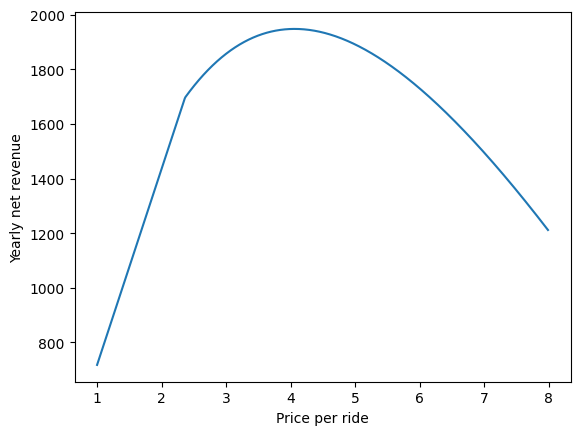

In [31]:
# Now we can plot the yearly net revenue as a function of the price per ride
import matplotlib.pyplot as plt
import numpy as np

# Create a list of prices per ride
price_per_ride = np.arange(1, 8, 0.01)

# Calculate the yearly net revenue for each price per ride
yearly_net_revenue_list = []
for i in price_per_ride:
    yearly_net_revenue_list.append(yearly_net_revenue(i, MONTHLY_RIDES_DRIVER))

# Plot the yearly net revenue as a function of the price per ride
plt.plot(price_per_ride, yearly_net_revenue_list)
plt.xlabel('Price per ride')
plt.ylabel('Yearly net revenue')
plt.show()


In [32]:
# Now we can optimize the price per ride to maximize the yearly net revenue
# We can use the scipy.optimize.minimize function to find the price per ride that maximizes the yearly net revenue

from scipy.optimize import minimize

# Define a function that returns the negative of the yearly net revenue
def negative_yearly_net_revenue(price_per_ride, monthly_rides=MONTHLY_RIDES_DRIVER):
    return -yearly_net_revenue(price_per_ride, monthly_rides)

# Find the price per ride that maximizes the yearly net revenue
result = minimize(negative_yearly_net_revenue, x0=6, method='SLSQP', bounds=[(1, 8)])
price_per_ride_optimized = result.x[0]
price_per_ride_optimized


4.06112649712701